<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/MoMu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema da Mochila com Múltiplas Escolhas

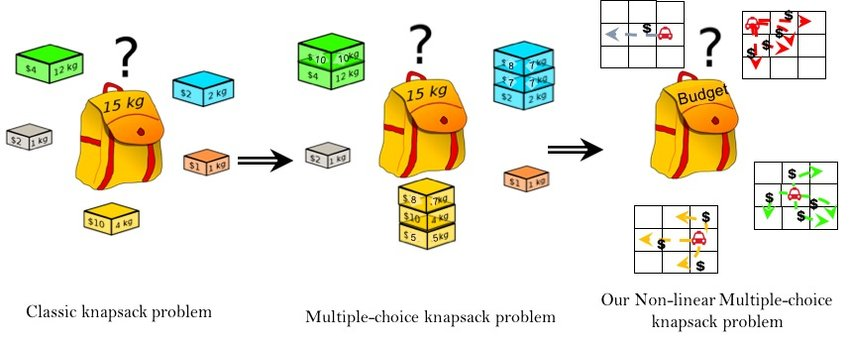

## Introdução

O problema da mochila é um dos problemas mais estudados em otimização combinatória, com muitas aplicações na vida real. Por esta razão, muitos casos especiais e generalizações foram examinados.

Comum a todas as versões é um conjunto de n itens, sendo que cada item 1 ≤ j ≤ n $1\leq j\leq n$ tem um lucro associado e um peso. A variável de decisão binária é usada para selecionar o item. O objetivo é escolher alguns dos itens, com lucro total máximo, obedecendo que o peso total máximo dos itens escolhidos não deve exceder a capacidade da mochila. Geralmente, esses coeficientes são escalonados para se tornarem inteiros, e quase sempre são assumidos como positivos.

Se os itens são divididos em $m$ classes e exatamente uma delas deve ser escolhida para cada item, então temos o problema da mochila com múltiplas escolhas. Abaixo segue uma formulação em programação inteira.

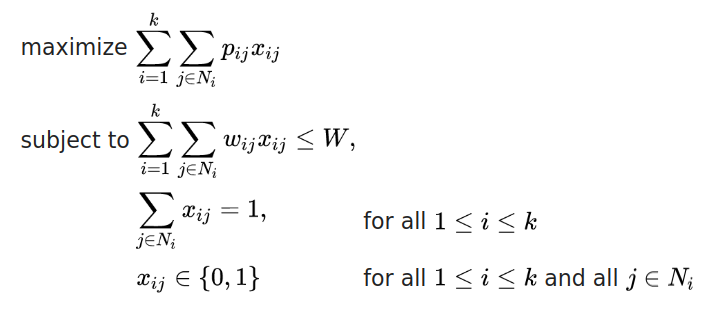

### Problema em dois níveis

Podemos dividir o problema em duas decisões: a primeira consiste em fixar um modo de escolha, uma classe, para cada item; e a segunda consiste em aproveitar essa simplificação e tomar a decisão para um problema da mochila 0-1: o item será escolhido naquele modo ou não.

Vamos utilizar uma busca dispersa para gerar os possíveis modos de escolha de cada item para uma população idealmente bastante diversa.

Em seguida, para cada elemento da população, uma heurística do tipo colônia de formigas é acionada para resolver o problema da mochila 0-1 com os modos fixados pela busca dispersa.

Com a solução da colônia de formigas agora vamos acionar um algoritmo de religação de caminhos entre todos os pares de soluções para encontrar soluções intermediárias que possam ser melhores. Neste passo, conforme os modos são modificados, pode haver uma tendência a passar por soluções inviáveis. Para reencontrar a viabilidade das soluções um método de busca local é acionado procurando a melhor solução vizinha viável trocando apenas um modo.

Vamos inicialmente definir a estrutura do problema com o número de objetos $n$, o número de modos ou classes de cada objeto $m$, os valores associados a cada objeto em cada modo $valor_{ij}$, o peso de cada objeto em cada modo $peso_{ij}$ e a $capacidade$ da mochila.

A estrutura da solução é a simples escolha de um $modo_i$ para cada $1 \leq i \leq n$.

In [21]:
import numpy
class MoMu:
  def __init__(self, n:int, m:int):
    self.n = n            # Número de objetos
    self.m = m            # Quantidade de modos por objeto
    self.valor = []       # Valores de cada objeto em cada modo
    self.peso = []        # Pesos de cada objeto em cada modo
    self.capacidade = 0   # Capacidade máxima da mochila

    self.modo = [0]*n     # Representação da solução
                          # Modo 0 => Peso = 0 e Valor = 0
    #self.valorObj = 0

  def valorObj(self):     # Valor da função objetivo para os modos escolhidos
    val = 0
    res = self.capacidade
    for j in range(self.n):
      val = val + self.valor[j][ self.modo[j] ]
      res = res - self.peso[j][ self.modo[j] ]
    if res < 0: val = res
    return val

  def residual(self):
    res = self.capacidade
    for j in range(self.n):
      res = res - self.peso[j][ self.modo[j] ]
    return res



### Gerando instâncias do problema

O código a seguir gera uma instância da mochila com múltiplas escolhas onde os valores e pesos serão gerados entre 1 e ```amplitude```. Já o parâmetro ```preenchimento``` se refere à capacidade da mochila que será igual a ```n * amplitude * preenchimento```.

In [22]:
def gerar_MoMu(n: int, m: int, amplitude = 100, preenchimento = 0.5, rseed = 233):

  random.seed(rseed)
  MM = MoMu(n, m)
  for i in range(n):
    seqvalor = [0] + random.sample(range(1,amplitude), m)
    seqpeso = [0] + random.sample(range(1,amplitude), m)
    seqvalor.sort()
    seqpeso.sort()
    MM.valor.append(seqvalor)
    MM.peso.append(seqpeso)

  MM.capacidade = amplitude * preenchimento * n
  return MM


## Busca dispersa

In [23]:
import random

def busca_dispersa(MM: MoMu,
                   tam_pop=25,                    # Quantidade de soluções na
                                                  #  busca dispersa
                   num_formigas=25,               # Quantidade de formigas por
                                                  #  solução
                   num_iter_ACO=25):              # Quantidade de iterações por
                                                  #  formiga

  melhor = copy.deepcopy(MM)                      # A melhor solução é iniciada
  for j in range(melhor.n): melhor.modo[j] = 0    # como uma solução nula

  pop = [MM]*tam_pop                              # Cada elemento da população
  for i in range(tam_pop):                        # tem um modo sorteado para
    for j in range(MM.n):                         # cada item da mochila. Em
      pop[i].modo[j] = random.choice(range(1,MM.m+1))
                                                  # seguida a otimização por
                                                  # colônia de formigas é chamada
    pop[i] = (ACO(pop[i],
                  num_formigas,
                  num_iter_ACO)).rodar()          # para cada um deles.

  for j in range(tam_pop):                        # Por fim, com as soluções da
    for i in range(j):                            # colônia de formigas, uma
      sol = religacao(pop[i], pop[j])             # religação de caminhos é feita
      if sol.valorObj() > melhor.valorObj():      # em busca da melhor solução
        melhor = copy.deepcopy(sol)               # intermidiária.

  return melhor

## Mochila 0-1 por Colônia de Formigas

In [24]:
import random
import copy
import numpy as np

class ACO:

  def __init__(self, MM:MoMu, num_formigas:int, num_iter: int):
    self.num_formigas = num_formigas
    self.num_iter = num_iter
    self.pop:MoMu = [MM]*num_formigas
    self.feromonio = [0.0]*MM.n
    self.decaimento:float = 0.9
    self.MM = MM


  def gerar_populacao(self):
    for i in range(self.num_formigas):
      ordarg = []
      for x in self.feromonio: ordarg.append(-x)
      ordem = list(np.argsort(ordarg))
      cap = self.pop[i].capacidade
      for j in range(self.MM.n):
        #indice = min( np.random.geometric(p=0.5), len(ordem)-1 )
        indice = random.choice( range(min(len(ordem), 3 )) )
        escolhido = ordem[indice]
        if self.pop[i].peso[escolhido][self.MM.modo[escolhido]] <= cap:
          cap = cap - self.pop[i].peso[escolhido][self.MM.modo[escolhido]]
        else:
          self.pop[i].modo[escolhido] = 0
        ordem.remove(escolhido)

  def iniciar_feromonios(self):
    for j in range(self.MM.n):
        if self.MM.modo[j] > 0 and self.MM.peso[j][self.MM.modo[j]] > 0:
            self.feromonio[j] = self.MM.valor[j][self.MM.modo[j]] / self.MM.peso[j][self.MM.modo[j]]
        else:
            self.feromonio[j] = 0.1

  def espalhar_feromonio(self, melhor:MoMu):
    # Decaimento
    for x in self.feromonio:
       x = x * self.decaimento

    # Reforço pela melhor solução
    for j in range(self.MM.n):
      if melhor.modo[j] > 0:

        self.feromonio[j] = self.feromonio[j] + self.MM.valor[j][self.MM.modo[j]]/self.MM.peso[j][self.MM.modo[j]]


  def rodar(self):
    melhor_de_todas = self.MM
    self.iniciar_feromonios()
    for iter in range(self.num_iter):
      self.gerar_populacao()
      melhor = max(self.pop, key = lambda x : x.valorObj())
      if melhor.valorObj() > melhor_de_todas.valorObj():
        melhor_de_todas = melhor

      self.espalhar_feromonio(melhor)

    return melhor


## Múltiplas escolhas por Religação de Caminhos

In [25]:
def busca_local(S: MoMu, k:int):
  melhor = copy.deepcopy(S)
  cap = melhor.residual()
  val = melhor.valorObj()

  for j in range(S.n):
    if j != k:
      for m in range(S.m):
        if m != S.modo[j]:
          if ( cap - S.peso[j][S.modo[j]] + S.peso[j][m] > 0
          and val - S.valor[j][S.modo[j]] + S.valor[j][m] > melhor.valorObj ):
             melhor = copy.deepcopy(S)
             melhor.modo[j] = m
  return melhor

In [26]:
def religacao(S:MoMu, R:MoMu):
  T = copy.deepcopy(S)
  melhor = copy.deepcopy(max([S,R], key = lambda x : x.valorObj()))
  for j in range(S.n):
    if S.modo[j] != R.modo[j]:
      T.modo[j] = R.modo[j]
      T = busca_local(T, j)
      if T.valorObj() > melhor.valorObj():
        melhor = copy.deepcopy(T)
  return melhor

In [27]:
MM = gerar_MoMu(20, 3)

for x in range(MM.n):
  print(f"Obj. {x}: Valores = {MM.valor[x]}, Pesos = {MM.peso[x]}")

sol = busca_dispersa(MM)

print(f"Valor da solução = {sol.valorObj()}")
print(f"Capacidade residual = {sol.residual()}")
print(f"Modos = {sol.modo}")


Obj. 0: Valores = [0, 23, 81, 88], Pesos = [0, 30, 62, 68]
Obj. 1: Valores = [0, 11, 27, 71], Pesos = [0, 14, 30, 35]
Obj. 2: Valores = [0, 2, 89, 92], Pesos = [0, 10, 31, 87]
Obj. 3: Valores = [0, 30, 78, 91], Pesos = [0, 15, 37, 96]
Obj. 4: Valores = [0, 28, 42, 62], Pesos = [0, 12, 38, 63]
Obj. 5: Valores = [0, 20, 68, 81], Pesos = [0, 43, 79, 91]
Obj. 6: Valores = [0, 13, 40, 65], Pesos = [0, 35, 58, 95]
Obj. 7: Valores = [0, 5, 52, 53], Pesos = [0, 8, 24, 95]
Obj. 8: Valores = [0, 9, 97, 98], Pesos = [0, 15, 21, 28]
Obj. 9: Valores = [0, 41, 46, 96], Pesos = [0, 17, 58, 67]
Obj. 10: Valores = [0, 4, 16, 60], Pesos = [0, 45, 90, 92]
Obj. 11: Valores = [0, 13, 85, 90], Pesos = [0, 11, 47, 73]
Obj. 12: Valores = [0, 8, 39, 51], Pesos = [0, 6, 70, 78]
Obj. 13: Valores = [0, 52, 60, 65], Pesos = [0, 1, 10, 93]
Obj. 14: Valores = [0, 46, 49, 62], Pesos = [0, 17, 58, 81]
Obj. 15: Valores = [0, 39, 45, 78], Pesos = [0, 18, 93, 95]
Obj. 16: Valores = [0, 27, 63, 69], Pesos = [0, 18, 52, 87

# Exercícios



1.   Existem dois métodos para conseguir soluções do problema da mochila com múltiplas escolhas implementado, a colônia de formigas e a ligação de caminhos. Descubra qual deles tem retornado de maneira mais frequente a melhor solução, ou seja: a ligação de caminhos consegue melhorar as soluções?




In [28]:
import random

def busca_dispersa_modificada(MM: MoMu,
                   tam_pop=25,                    # Quantidade de soluções na
                                                  #  busca dispersa
                   num_formigas=25,               # Quantidade de formigas por
                                                  #  solução
                   num_iter_ACO=25,               # Quantidade de iterações por
                                                  #  formiga
                   verbose = True
                   ):
  count_aco = 0
  count_religacao = 0
  melhor = copy.deepcopy(MM)                      # A melhor solução é iniciada
  for j in range(melhor.n): melhor.modo[j] = 0    # como uma solução nula

  # Será quantificado as vez que religação melhorou a solução

  pop = [MM]*tam_pop                              # Cada elemento da população
  for i in range(tam_pop):                        # tem um modo sorteado para
    for j in range(MM.n):                         # cada item da mochila. Em
      pop[i].modo[j] = random.choice(range(1,MM.m+1))
                                                  # seguida a otimização por
                                                  # colônia de formigas é chamada
    pop[i] = (ACO(pop[i],
                  num_formigas,
                  num_iter_ACO)).rodar()          # para cada um deles.

  for j in range(tam_pop):                        # Por fim, com as soluções da
    for i in range(j):                            # colônia de formigas, uma
      sol = religacao(pop[i], pop[j])             # religação de caminhos é feita
      if sol.valorObj() > melhor.valorObj():      # em busca da melhor solução
        melhor = copy.deepcopy(sol)
        count_religacao +=1
      else:
        count_aco +=1              # intermidiária.

  if verbose:
    print(f'Quantidade de vezes que a solução ACO não foi modificada :{count_aco}')
    print(f'Quantidade de vezes que a solução RELIGACAO foi modificada :{count_religacao}')

  return melhor

In [29]:
busca_dispersa_modificada(gerar_MoMu(100, 6))

Quantidade de vezes que a solução ACO não foi modificada :299
Quantidade de vezes que a solução RELIGACAO foi modificada :1


>

2.   Elabore uma bateria de testes com diferentes valores de amplitude e preenchimento para as instâncias, bem como diferentes parâmetros para as heurísticas. Que conclusões você consegue chegar com a análise dos resultados?

In [30]:
from itertools import product
tests = (
    (20, 3, 100, 0.3),
    (20, 3, 100, 0.5),
    (20, 3, 100, 0.8),
    (20, 3, 150, 0.3),
    (20, 3, 150, 0.5),
    (20, 3, 150, 0.8),
    (20, 3, 200, 0.3),
    (20, 3, 200, 0.5),
    (20, 3, 200, 0.8),
    (20, 3, 50 , 0.3),
    (20, 3, 50, 0.5),
    (20, 3, 50, 0.8),

)
num_formigas_opcoes  = [10, 25, 50]
num_populucao_opcoes = [10, 25, 50]
num_iteracoes_opcoes = [10, 25, 50]

index1 = [0, 1, 2]
index2 = [0, 1, 2]
index3 = [0, 1, 2]
# Gera combinações com repetição
combinacoes = [(x, y, z) for x, y, z in product(index1, index2, index3)]
combinacoes

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [31]:
# Teste
dicionario = dict(
    solucao = [],
    solucao_residual = [],
    numero_objetos = [],
    quantidade_de_modos = [],
    amplitude = [],
    preenchimento = [],
    tam_pop = [],
    num_formigas=[],
    num_iter_ACO=[]
)
for test in tests:
    for formigas, pop, numIter in combinacoes:
        numPop = num_populucao_opcoes[pop]
        numForm = num_formigas_opcoes[formigas]
        numIterACO = num_iteracoes_opcoes[numIter]

        S = busca_dispersa(gerar_MoMu(*test), tam_pop=numPop, num_formigas=numForm, num_iter_ACO=numIterACO)
        dicionario['solucao'].append(S.valorObj())
        dicionario['solucao_residual'].append(S.residual())
        dicionario['numero_objetos'].append(test[0])
        dicionario['quantidade_de_modos'].append(test[1])
        dicionario['amplitude'].append(test[2])
        dicionario['preenchimento'].append(test[3])
        dicionario['tam_pop'].append(numPop)
        dicionario['num_formigas'].append(numForm)
        dicionario['num_iter_ACO'].append(numIterACO)

In [38]:
import pandas as pd
data = pd.DataFrame(dicionario)

In [39]:
data.sort_values(by='solucao', ascending=False, inplace=True)

In [40]:
data[['solucao','solucao_residual']].corr()

,solucao,solucao_residual
solucao,1.000000,0.397746
solucao_residual,0.397746,1.000000


<Axes: xlabel='solucao', ylabel='solucao_residual'>

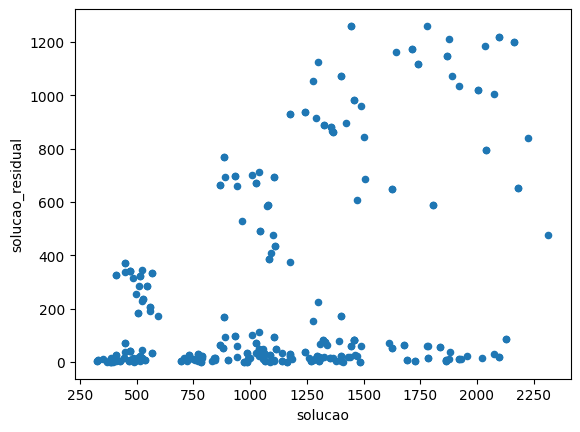

In [41]:
data[['solucao','solucao_residual']].plot.scatter(x='solucao', y='solucao_residual')

> Vemos que há uma correlaçao positiva entre os residual quanto maior o residuo maior é o valor da solução

In [42]:
data.corr()[['solucao', 'solucao_residual']]

,solucao,solucao_residual
solucao,1.000000,0.397746
solucao_residual,0.397746,1.000000
numero_objetos,NaN,NaN
quantidade_de_modos,NaN,NaN
amplitude,0.923713,0.268157
preenchimento,0.230340,0.801445
tam_pop,-0.037736,-0.026528
num_formigas,-0.018609,0.022219
num_iter_ACO,-0.018609,0.022219


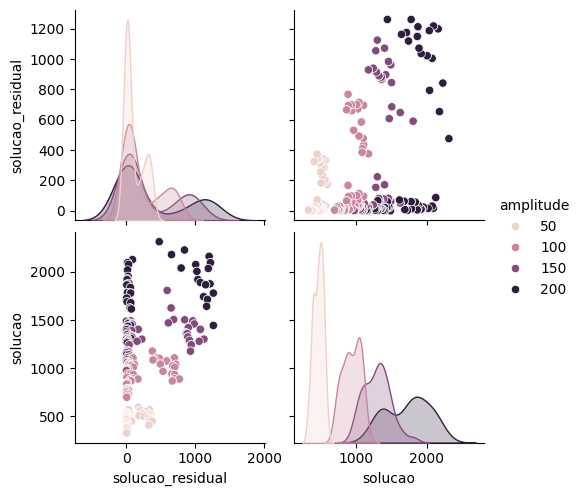

In [45]:
import seaborn as sea
sea.pairplot(data[['amplitude','solucao_residual','solucao']], hue='amplitude')

> Quanto maior for a amplitude maior serão a solução e o erro residual

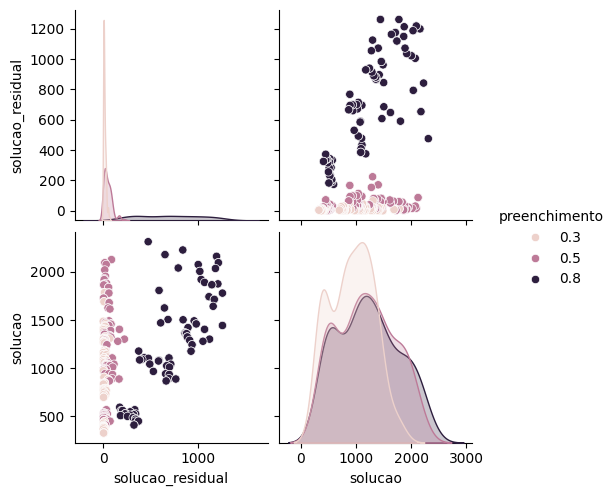

In [46]:
sea.pairplot(data[['preenchimento','solucao_residual','solucao']], hue='preenchimento')

> Quanto maior a amplitude maior são a solução o residuo

Amplitude e preenchimento influenciam muito na solução do problema, as demais não imfluenciaram muito